# طراحی و آموزش شبکه‌ی عصبی کانولوشنی (CNN) برای طبقه‌بندی جت‌های WZ و QCD

در این بخش قصد داریم از **شبکه‌های عصبی کانولوشنی (CNN)** برای **طبقه‌بندی جت‌های حاصل از فرایندهای WZ و QCD** استفاده کنیم.

### 🎯 هدف

هدف اصلی ما این است که شبکه یاد بگیرد تفاوت ساختاری بین جت‌های حاصل از فرآیند W → jj (در WZ) و جت‌های QCD (حاصل از کوارک یا گلئون) را شناسایی کند. از آنجایی که ساختار جت‌ها حاوی اطلاعاتی درباره منشأ آن‌ها است، ما از آن بهره می‌گیریم.

### 🗺️ نمایش جت به‌صورت تصویر

برای استفاده از CNN، نیاز داریم که داده‌های ورودی را به فرم تصویر درآوریم. ما از **مختصات η (اتا) و φ (فی)** برای ایجاد یک شبکه دوبعدی استفاده می‌کنیم. در این نقشه:

- محور افقی: φ (زاویه قطبی حول محور پرتو)
- محور عمودی: η (متغیر مربوط به زاویه ضربه ذره نسبت به محور پرتو)
- شدت (رنگ پیکسل): میزان `pt` ذره در آن سلول (به‌صورت وزن‌شده)

به این ترتیب، **برای هر جت یک "نقشه حرارتی (heatmap)" از توزیع انرژی ذرات در فضای η–φ خواهیم داشت**.

### 🧱 داده‌های ورودی

- ما از داده‌های HDF5 استفاده می‌کنیم که در مقاله [RODEM – arXiv:2408.11616](https://arxiv.org/abs/2408.11616) آمده‌اند.
- مؤلفه‌های جت اول (`jet1_cnsts`) را استخراج می‌کنیم.
- برای هر ایونت، یک تصویر ۲بعدی با اندازه ثابت (مثلاً 100x100) تولید می‌کنیم که نشان‌دهنده توزیع `pt` در η–φ است.
- لیبل `0` برای کلاس QCD و لیبل `1` برای کلاس WZ استفاده خواهد شد.




In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import h5py
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

### دانلود و آماده سازی داده ها

In [ ]:
import urllib.request
import tarfile

filename = 'CPHdata.tar.gz'

# دانلود فایل
print('Downloading...')
urllib.request.urlretrieve("https://hbakhshi.web.cern.ch/hbakhshi/IUT/TMP/CPHdata.tar.gz", filename)
print('Download completed.')

# استخراج فایل tar.gz
print('Extracting...')
with tarfile.open(filename, 'r:gz') as tar:
    tar.extractall(path=".")
print('Extraction completed.')


## ⚙️ تنظیمات پروژه تشخیص جت با CNN در فضای η–φ

در این بخش، ما تنظیمات اولیه‌ی پروژه‌ی یادگیری ماشین برای طبقه‌بندی جت‌های حاصل از فرایندهای WZ (سیگنال) و QCD (پس‌زمینه) را تعریف می‌کنیم. این تنظیمات شامل مسیر داده‌ها، ابعاد تصاویر، پارامترهای آموزش، و تعریف GPU/CPU هستند.

### ⚙️ جزئیات پارامترهای `Config`

کلاس `Config` نقش ستون فقرات تنظیمات پروژه را ایفا می‌کند. در این کلاس، مسیر داده‌ها، ویژگی‌های مدل، و تنظیمات آموزش مشخص می‌شوند.

| نام پارامتر        | مقدار نمونه                              | توضیح کامل |
|-------------------|------------------------------------------|------------|
| `SIGNALS_PATH`    | `'./'`                                   | مسیر دایرکتوری فایل‌های **سیگنال** (مانند WZ) |
| `BKG_PATH`        | `'./'`                                   | مسیر فایل‌های **پس‌زمینه** (مانند QCD) |
| `SIGNALS`         | `['WZ_jjnunu_pT_450_1200_test.h5']`      | لیستی از فایل‌های مربوط به داده‌های **سیگنال** |
| `BKGS`            | `['QCDjj_pT_450_1200_test.h5']`          | لیستی از فایل‌های مربوط به داده‌های **پس‌زمینه** |
| `IMAGE_SIZE`      | `32`                                     | ابعاد تصویر تولیدشده از داده‌ها در صفحه‌ی η–φ به‌صورت `IMAGE_SIZE × IMAGE_SIZE` |
| `BATCH_SIZE`      | `64`                                     | تعداد تصاویر در هر دسته (Batch) در طول آموزش |
| `EPOCHS`          | `10`                                     | تعداد تکرار آموزش روی کل داده‌ها |
| `LR`              | `1e-3`                                   | نرخ یادگیری (Learning Rate) برای به‌روزرسانی وزن‌ها |
| `NUM_CLASSES`     | `2`                                      | تعداد کلاس‌ها برای طبقه‌بندی (۰ = QCD، ۱ = WZ) |
| `DEVICE`          | `torch.device("cuda" if torch.cuda.is_available() else "cpu")` | به‌صورت خودکار مشخص می‌کند که از GPU استفاده شود یا CPU (اگر GPU در دسترس باشد، استفاده می‌شود) |

---

🎯 **نکته:**  
با استفاده از کلاس `Config` می‌توانیم تغییرات اصلی پروژه را تنها با ویرایش یک محل انجام دهیم؛ این باعث ساختار بهتر، نگهداری آسان‌تر، و قابلیت بازاستفاده بالا می‌شود.



In [ ]:
class Config:
    SIGNALS_PATH = './'
    BKG_PATH = './'
    SIGNALS = ['mini_WZ_jjnunu_pT_450_1200_test.h5']
    BKGS = ['mini_QCDjj_pT_450_1200_test.h5']
    IMAGE_SIZE = 32
    BATCH_SIZE = 64
    EPOCHS = 10
    LR = 1e-3
    NUM_CLASSES = 2        
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 📂 توابع کمکی برای بارگذاری مسیر فایل‌ها و برچسب‌ها

### 🔧 `AllFiles()` — لیست مسیر کامل فایل‌ها

این تابع مسیر کامل تمام فایل‌های HDF5 را بازمی‌گرداند. فایل‌ها از دو نوع سیگنال (مانند WZ) و پس‌زمینه (مانند QCD) هستند.

#### 📥 ورودی:
- بدون ورودی خارجی – فایل‌ها بر اساس مقادیر تعریف‌شده در کلاس `Config` بارگذاری می‌شوند.

#### 📤 خروجی:
- لیستی از مسیرهای کامل فایل‌ها از هر دو مجموعه‌ی `SIGNALS` و `BKGS`.

#### 🧠 منطق:
1. برای هر فایل در `Config.SIGNALS`، مسیر آن به کمک `Path` به `Config.SIGNALS_PATH` الصاق می‌شود.
2. برای هر فایل در `Config.BKGS`، مسیر آن به `Config.BKG_PATH` الصاق می‌شود.
3. ترکیب نهایی مسیرها (Signals + Backgrounds) به عنوان خروجی بازگردانده می‌شود.
---

## 🏷️ تابع `GetLabels()` — تولید برچسب کلاس برای هر فایل

تابع `GetLabels()` یک لیست از لیبل‌ها (برچسب‌های کلاس) برای فایل‌هایی که در آموزش مدل استفاده می‌شوند، تولید می‌کند.

### 🎯 هدف:
تشخیص این که هر فایل ورودی مربوط به **سیگنال (Signal)** است یا **پس‌زمینه (Background)**.

### 📥 ورودی:
- این تابع ورودی مستقیم ندارد، بلکه از مقادیر موجود در کلاس `Config` استفاده می‌کند:
  - `Config.SIGNALS`: لیست فایل‌های مربوط به سیگنال (مثلاً WZ)
  - `Config.BKGS`: لیست فایل‌های پس‌زمینه (مثلاً QCD)

### 📤 خروجی:
- یک لیست از اعداد صحیح (integers) با طول برابر با مجموع تعداد فایل‌های سیگنال و پس‌زمینه.
  - عدد `1` برای فایل‌های سیگنال
  - عدد `0` برای فایل‌های پس‌زمینه

### 🧠 منطق عملکرد:
1. برای هر فایل در `Config.SIGNALS`، مقدار ۱ به لیست اضافه می‌شود.
2. برای هر فایل در `Config.BKGS`، مقدار ۰ به لیست اضافه می‌شود.
3. ترتیب لیبل‌ها دقیقاً با ترتیب فایل‌ها در تابع `AllFiles()` همخوانی دارد، تا هنگام بارگذاری در Dataset دچار mismatch نشویم.



In [8]:
def AllFiles():
    ret = []
    for signal in Config.SIGNALS:
        ret.append(Path(Config.SIGNALS_PATH) / signal)
    for bkg in Config.BKGS:
        ret.append(Path(Config.BKG_PATH) / bkg)
    return ret
def GetLabels():
    labels = []
    for signal in Config.SIGNALS:
        labels.append(1)  # Signal class
    for bkg in Config.BKGS:
        labels.append(0)  # Background class
    return labels

## 🖼️ تابع `create_image` — ساخت تصویر دوبعدی از جت بر اساس ویژگی‌های مؤلفه‌ها

این تابع وظیفه دارد با استفاده از ویژگی‌های ذرات تشکیل‌دهنده‌ی یک جت (مانند `pt`, `mass`, `charge`, `eta`, و `phi`) یک **نقشه حرارتی دوبعدی** (تصویر) از جت ایجاد کند. این تصویر می‌تواند برای ورودی مدل‌های یادگیری عمیق (به‌ویژه CNN) استفاده شود.

---

### 🎯 هدف:
تبدیل اطلاعات فیزیکی جت به یک تصویر ۲D با سه کانال (RGB)، جایی که:
- کانال قرمز (R): شدت `pt` هر سلول،
- کانال سبز (G): جرم `mass` هر سلول،
- کانال آبی (B): مجموع `charge` ذرات در هر سلول.

---

### ⚙️ ورودی‌ها:
| نام متغیر | نوع داده | توضیح |
|----------|----------|-------|
| `pt`     | `np.array` | آرایه‌ی `pt` مؤلفه‌های جت |
| `mass`   | `np.array` | جرم مؤلفه‌ها |
| `charge` | `np.array` | بار الکتریکی مؤلفه‌ها |
| `eta`    | `np.array` | موقعیت pseudorapidity |
| `phi`    | `np.array` | موقعیت زاویه‌ای |
| `size`   | `int`      | اندازه تصویر خروجی (تعداد پیکسل‌ها در هر محور)

---

### 🧮 مراحل پردازش:

1. **ساخت تصویر خام**:
   - ایجاد آرایه صفر با ابعاد `(size, size, 3)` برای ذخیره مقادیر `pt`, `mass`, `charge` در سه کانال RGB.

2. **نرمال‌سازی مقادیر `eta` و `phi` به فضای تصویر**:
   - `eta` به بازه `[0, size-1]` نگاشت می‌شود.
   - `phi` ابتدا به بازه `(-π, π]` نگاشت شده و سپس به `[0, size-1]`.

3. **انباشتن ویژگی‌ها در مختصات پیکسلی**:
   - برای هر مؤلفه جت، اگر `pt > 0` باشد:
     - مختصات تصویری آن محاسبه شده و در هر کانال مقدار مربوطه افزوده می‌شود.

4. **نرمال‌سازی نهایی تصویر**:
   - هر کانال جداگانه طوری نرمال می‌شود که حداکثر مقدار آن ۱ شود. این کار به شبکه کمک می‌کند بهتر یاد بگیرد.

---

### 📤 خروجی:
یک آرایه‌ی `numpy` با ابعاد `(size, size, 3)` که نمایانگر تصویر ویژگی‌های جت در صفحه `η-φ` است. این تصویر برای ورودی به CNN آماده است.

---

### 📌 نکته علمی:
استفاده از `η` و `φ` به‌جای مختصات دکارتی، به ما این امکان را می‌دهد که نمایشی زاویه‌ای و نسبی از ذرات درون جت داشته باشیم، مشابه تصویری که آشکارسازهای ذرات ثبت می‌کنند.

---




In [22]:
def create_image(pt, mass , charge , eta, phi, size):
    image = np.zeros((size, size , 3), dtype=np.float32)

    min_eta = np.min(eta)
    max_eta = np.max(eta)
    phi = np.mod(phi + np.pi, 2 * np.pi) - np.pi

    eta_idx = (((eta - min_eta) / (max_eta - min_eta)) * (size - 1)).astype(int)
    phi_idx = (((phi + np.pi) / (2 * np.pi)) * (size - 1)).astype(int)

    for i in range(len(pt)):
        if pt[i] > 0:
            x, y = eta_idx[i], phi_idx[i]
            image[y, x , 0] += pt[i]
            image[y, x , 1] += mass[i]
            image[y, x , 2] += charge[i]
    
    image[:,:,0] /= np.max(image[:,:,0]) if np.max(image[:,:,0]) > 0 else 1
    image[:,:,1] /= np.max(image[:,:,1]) if np.max(image[:,:,1]) > 0 else 1
    image[:,:,2] /= np.max(image[:,:,2]) if np.max(image[:,:,2]) > 0 else 1

    return image


## کلاس `JetImageDataset`

### پارامترهای ورودی سازنده (`__init__`)

| پارامتر      | نوع داده         | توضیح                                                      |
|--------------|------------------|------------------------------------------------------------|
| `h5_paths`   | `list`           | لیست مسیر فایل‌های HDF5 که داده‌های جت را نگه می‌دارند.  |
| `labels`     | `list`           | لیست برچسب‌های مربوط به هر فایل (0 برای پس‌زمینه، 1 برای سیگنال). |
| `image_size` | `int`            | اندازه تصویر ساخته شده (مثلاً 32 برای تصویر 32×32 پیکسل). |
| `n_jets`     | `int` (اختیاری)  | تعداد جت‌هایی که باید از هر فایل خوانده شود؛ `-1` برای خواندن همه. |

---

### متغیرهای داخلی (attributes)

| نام متغیر       | نوع داده             | توضیح                                                                                       |
|-----------------|----------------------|---------------------------------------------------------------------------------------------|
| `self.pt`       | `numpy.ndarray`      | آرایه‌ای شامل مقدار `pt` مؤلفه‌های جت‌ها برای همه نمونه‌ها.                               |
| `self.eta`      | `numpy.ndarray`      | آرایه‌ای شامل مقدار η (eta) مؤلفه‌های جت‌ها برای همه نمونه‌ها.                            |
| `self.phi`      | `numpy.ndarray`      | آرایه‌ای شامل مقدار φ (phi) مؤلفه‌های جت‌ها برای همه نمونه‌ها.                            |
| `self.mass`     | `numpy.ndarray`      | آرایه‌ای شامل جرم مؤلفه‌های جت‌ها برای همه نمونه‌ها.                                     |
| `self.charge`   | `numpy.ndarray`      | آرایه‌ای شامل بار الکتریکی مؤلفه‌های جت‌ها برای همه نمونه‌ها.                            |
| `self.labels`   | `numpy.ndarray`      | آرایه برچسب‌ها (labels) که کلاس هر جت را مشخص می‌کند.                                     |
| `self.image_size`| `int`                | اندازه‌ی تصویر (طول و عرض به پیکسل) که برای هر نمونه ساخته می‌شود.                        |

---

## متدها

### `__init__(self, h5_paths, labels, image_size, n_jets=-1)`

- سازنده کلاس.
- وظیفه بارگذاری داده‌ها از فایل‌های HDF5 و آماده‌سازی آرایه‌های ویژگی‌ها و برچسب‌ها.
- بررسی وجود فایل‌ها و بارگذاری مؤلفه‌های جت: `pt`, `eta`, `phi`, `mass`, `charge`.
- الحاق داده‌ها از چند فایل به صورت پشت سر هم.

---

### `__len__(self)`

- بازگشت تعداد کل نمونه‌ها (تعداد جت‌ها).
- پیاده‌سازی شده تا با `DataLoader`های PyTorch سازگار باشد.
- امضا:  
  ```python
  def __len__(self):
      return len(self.pt)


In [23]:
class JetImageDataset(Dataset):
    def __init__(self, h5_paths, labels , image_size  , n_jets = -1):
        super(JetImageDataset, self).__init__()

        self.pt = None
        self.eta = None
        self.phi = None
        self.mass = None
        self.charge = None
        self.labels = np.array([])
        for h5_path , lbl in zip(h5_paths, labels):
            if not Path(h5_path).exists():
                raise FileNotFoundError(f"File {h5_path} does not exist.")
            with h5py.File(h5_path, 'r') as f:
                cnsts = f["objects/jets/jet1_cnsts"][:n_jets]
                #jets = f["objects/jets/jet1_obs"][:n_jets]
                if self.pt is None:
                    self.pt = cnsts[:,:,0]
                    self.eta = cnsts[:,:,1]
                    self.phi = cnsts[:,:,2]
                    self.mass = cnsts[:,:,3]
                    self.charge = cnsts[:,:,4]
                else:
                    self.pt = np.concatenate( [self.pt ,  cnsts[:,:,0]] )
                    self.eta = np.concatenate( [self.eta ,  cnsts[:,:,1]] )
                    self.phi = np.concatenate( [self.phi ,  cnsts[:,:,2]] )
                    self.mass = np.concatenate( [self.mass ,  cnsts[:,:,3]] )
                    self.charge = np.concatenate( [self.charge ,  cnsts[:,:,4]] )

                njets = cnsts.shape[0]
                self.labels = np.concatenate( [self.labels , np.full(njets, lbl)] )
        
        self.image_size = image_size

    def __len__(self):
        return len(self.pt)

    def __getitem__(self, idx):
        image = create_image(
        self.pt[idx],
        self.mass[idx],
        self.charge[idx],
        self.eta[idx],
        self.phi[idx],
        self.image_size
    )
        image = np.transpose(image, (2, 0, 1))  # تبدیل [H, W, C] به [C, H, W]
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(self.labels[idx]).long()
        return image, label



In [24]:
j = JetImageDataset( AllFiles(), GetLabels(), Config.IMAGE_SIZE, n_jets=100)

### نمایش به واسطه کلاس matplotlib

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


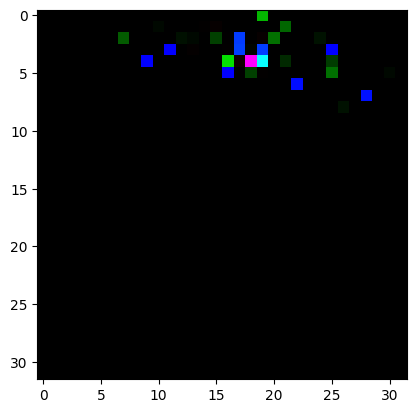

In [28]:
from matplotlib import pyplot as plt
plt.imshow( j[120][0][0,:,:,:] )

## کلاس `CNNClassifier`

این کلاس یک مدل شبکه عصبی پیچشی (CNN) ساده برای دسته‌بندی دو کلاس (مثل جت‌های WZ و QCD) تعریف می‌کند.  
کلاس از `torch.nn.Module` ارث‌بری می‌کند و شامل چند لایه کانولوشن، فعال‌سازی، کاهش ابعاد و در نهایت لایه‌های خطی (Fully Connected) است.

---

## متدها و اجزای کلاس

### 1. متد سازنده: `__init__(self, num_classes)`

- ورودی:
  - `num_classes` (int): تعداد کلاس‌های خروجی که مدل باید آنها را تشخیص دهد (مثلاً ۲ برای WZ و QCD).

- کاری که انجام می‌دهد:
  - با استفاده از `super()`، سازنده کلاس پدر (`nn.Module`) را فراخوانی می‌کند.
  - سپس یک شبکه عصبی به صورت زنجیره‌ای (`nn.Sequential`) تعریف می‌کند که شامل چندین لایه است:

#### ساختار لایه‌ها:

| نوع لایه             | مشخصات                               | توضیح                                   |
|----------------------|------------------------------------|----------------------------------------|
| `nn.Conv2d(1, 16, kernel_size=3, padding=1)` | کانولوشن ۲ بعدی با ۱ کانال ورودی و ۱۶ فیلتر، هسته ۳×۳، padding=1 | استخراج ویژگی‌های اولیه از تصویر ورودی تک‌کاناله |
| `nn.ReLU()`           | تابع فعال‌سازی ReLU                 | افزودن غیرخطی بودن                      |
| `nn.MaxPool2d(2)`     | ماکس‌پولینگ با اندازه ۲×۲          | کاهش ابعاد فضایی به نصف در هر بعد      |
| `nn.Conv2d(16, 32, kernel_size=3, padding=1)`| کانولوشن ۲ بعدی با ۱۶ کانال ورودی و ۳۲ فیلتر، هسته ۳×۳، padding=1 | استخراج ویژگی‌های پیچیده‌تر            |
| `nn.ReLU()`           | تابع فعال‌سازی ReLU                 | افزودن غیرخطی بودن                      |
| `nn.MaxPool2d(2)`     | ماکس‌پولینگ با اندازه ۲×۲          | کاهش دوباره ابعاد فضایی به نصف         |
| `nn.Flatten()`        | صاف کردن (Flatten) داده‌ها         | تبدیل خروجی ۴ بعدی به بردار ۱ بعدی    |
| `nn.Linear(32 * (Config.IMAGE_SIZE // 4) ** 2, 64)` | لایه خطی (Fully Connected) با ورودی متناسب با ابعاد خروجی از لایه‌های قبلی و 64 نورون خروجی | کاهش ابعاد و استخراج ترکیبات خطی ویژگی‌ها |
| `nn.ReLU()`           | تابع فعال‌سازی ReLU                 | افزودن غیرخطی بودن                      |
| `nn.Linear(64, num_classes)` | لایه خطی خروجی با تعداد نورون برابر تعداد کلاس‌ها | پیش‌بینی احتمال تعلق نمونه به هر کلاس |

---

### نکته درباره ابعاد

- تصویر ورودی اندازه‌ای برابر با `Config.IMAGE_SIZE × Config.IMAGE_SIZE` دارد (مثلاً ۳۲×۳۲).
- دو بار ماکس‌پولینگ با اندازه ۲ انجام شده، پس ابعاد بعد از کانولوشن‌ها کاهش می‌یابد به:  
  \[
  \frac{\text{IMAGE_SIZE}}{2} \to \frac{\text{IMAGE_SIZE}}{4}
  \]
- تعداد کانال‌ها در آخرین لایه کانولوشن برابر ۳۲ است.
- پس ابعاد ورودی لایه خطی برابر است با:  
  \[
  32 \times \left(\frac{\text{IMAGE_SIZE}}{4}\right)^2
  \]

---

### 2. متد `forward(self, x)`

- ورودی:
  - `x`: ورودی داده به مدل؛ معمولاً یک تنسور ۴ بعدی با ابعاد (batch_size, channels=1, height, width).
  
- عملکرد:
  - داده ورودی را به مدل `self.net` می‌دهد تا به صورت مرحله‌به‌مرحله از لایه‌ها عبور کند.
  - خروجی نهایی پیش‌بینی مدل برای هر نمونه است (تعداد نورون‌های خروجی برابر با تعداد کلاس‌ها).

- امضا و پیاده‌سازی:  
  ```python
  def forward(self, x):
      return self.net(x)


In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32 * (Config.IMAGE_SIZE // 4) ** 2, 64), nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)


## توضیح کامل و مفصل تابع `train`

تابع `train` مسئول آموزش مدل شبکه عصبی کانولوشنی (CNN) است که داده‌ها را به صورت دسته‌ای (batch) پردازش کرده، خطای مدل را در هر مرحله محاسبه می‌کند و با استفاده از الگوریتم بهینه‌سازی وزن‌های مدل را به‌روزرسانی می‌نماید. این روند به تعداد مشخصی دوره یا epoch تکرار می‌شود تا مدل به تدریج یادگیری خود را بهبود دهد.

---
## شرح جزئیات کد تابع train

- `model.train()`  
  مدل را در حالت آموزش قرار می‌دهد تا لایه‌هایی مثل Dropout و BatchNorm به درستی رفتار کنند.

- `loss_history = []`  
  لیستی برای ذخیره میانگین مقادیر loss در هر epoch جهت تحلیل روند آموزش.

- `for epoch in range(epochs):`  
  حلقه اصلی آموزش که به تعداد epoch مشخص شده، اجرا می‌شود.

- `epoch_loss = 0`  
  متغیری برای جمع‌آوری مجموع loss در هر epoch.

- `for images, labels in loader:`  
  حلقه روی batches داده‌های ورودی (تصاویر و برچسب‌ها) از DataLoader.

- `images, labels = images.to(device), labels.to(device)`  
  انتقال داده‌ها به دستگاه محاسباتی (CPU یا GPU).

- `optimizer.zero_grad()`  
  صفر کردن گرادیان‌های انباشته شده قبل از شروع backpropagation.

- `outputs = model(images)`  
  اجرای مدل روی تصاویر برای بدست آوردن پیش‌بینی‌ها.

- `loss = criterion(outputs, labels)`  
  محاسبه مقدار تابع خطا (Loss) بین پیش‌بینی مدل و برچسب‌های واقعی.

- `loss.backward()`  
  محاسبه گرادیان‌ها نسبت به پارامترهای مدل با الگوریتم backpropagation.

- `optimizer.step()`  
  به‌روزرسانی وزن‌های مدل بر اساس گرادیان‌ها.

- `epoch_loss += loss.item()`  
  جمع‌آوری مقدار عددی loss برای میانگین‌گیری در انتهای epoch.

- `avg_loss = epoch_loss / len(loader)`  
  محاسبه میانگین loss در کل batchهای یک epoch.

- `loss_history.append(avg_loss)`  
  ذخیره میانگین loss هر epoch برای تحلیل روند آموزش.

- `print(f"[Epoch {epoch+1}/{epochs}] Loss: {avg_loss:.4f}")`  
  نمایش مقدار loss هر epoch به صورت زنده.

- `return loss_history`  
  بازگرداندن لیست مقادیر loss برای بررسی و رسم نمودار کاهش خطا.



In [ ]:
def train(model, loader, criterion, optimizer, epochs, device):
    model.train()
    loss_history = []

    for epoch in range(epochs):
        epoch_loss = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(loader)
        loss_history.append(avg_loss)
        print(f"[Epoch {epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

    return loss_history


## توضیح تابع `plot_losses`

- `plt.figure(figsize=(8, 5))`  
  ایجاد یک شکل (figure) با اندازه ۸ در ۵ اینچ برای ترسیم نمودار.

- `plt.plot(losses, marker='o')`  
  رسم نمودار خطی از داده‌های `losses` که معمولاً مقادیر خطای آموزش در هر epoch هستند.  
  پارامتر `marker='o'` باعث می‌شود هر نقطه داده با دایره نمایش داده شود.

- `plt.title("Training Loss")`  
  اضافه کردن عنوان "Training Loss" به نمودار.

- `plt.xlabel("Epoch")`  
  برچسب محور افقی (x-axis) به نام "Epoch" که تعداد دوره‌های آموزش را نشان می‌دهد.

- `plt.ylabel("Loss")`  
  برچسب محور عمودی (y-axis) به نام "Loss" که مقدار خطا را نشان می‌دهد.

- `plt.grid(True)`  
  فعال کردن خطوط شبکه‌ای (grid) در پس‌زمینه نمودار برای خوانایی بهتر.

- `plt.show()`  
  نمایش نمودار رسم شده به کاربر.


In [ ]:
def plot_losses(losses):
    plt.figure(figsize=(8, 5))
    plt.plot(losses, marker='o')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()


In [ ]:
dataset = JetImageDataset( AllFiles(), GetLabels(), Config.IMAGE_SIZE, n_jets=100)
dataloader = DataLoader(dataset, batch_size=Config.BATCH_SIZE, shuffle=True)

model = CNNClassifier(Config.NUM_CLASSES).to(Config.DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=Config.LR)

losses = train(model, dataloader, criterion, optimizer, Config.EPOCHS, Config.DEVICE)

plot_losses(losses)


## جمع‌بندی نهایی درس: طراحی و آموزش شبکه عصبی کانولوشنی برای تشخیص جت‌ها در فیزیک ذرات

دانشجویان گرامی،

در این دوره، ما قدم به قدم با یک مسئله عملی در فیزیک ذرات آشنا شدیم: تشخیص دسته‌بندی جت‌های WZ و QCD با استفاده از داده‌های پیچیده آزمایشگاهی. هدف اصلی ما توسعه یک مدل یادگیری عمیق مبتنی بر شبکه‌های عصبی کانولوشنی (CNN) بود که بتواند تصاویر بازنمایی شده از ویژگی‌های فیزیکی ذرات را به درستی دسته‌بندی کند.

---

## مرور کلی مراحل انجام شده

### 1. آماده‌سازی و تنظیمات اولیه  
- تعریف یک کلاس `Config` جامع برای مدیریت پارامترهای پروژه شامل مسیر داده‌ها، نام فایل‌ها، اندازه تصاویر، پارامترهای آموزش و دستگاه اجرا.

### 2. مدیریت داده‌ها  
- توابع `AllFiles` و `GetLabels` برای بارگذاری لیست فایل‌های داده و برچسب‌های مربوط به سیگنال و پس‌زمینه.  
- بارگذاری داده‌ها از فرمت HDF5 و استخراج ویژگی‌های فیزیکی ذرات.

### 3. تبدیل داده‌ها به تصاویر  
- طراحی تابع `create_image` که ویژگی‌های مهم هر ذره (مانند پی‌تی، جرم، بار) را به صورت نقشه حرارتی سه کاناله در مختصات η و φ مدل‌سازی می‌کند.  
- این مرحله، داده‌های عددی پیچیده را به قالبی تبدیل می‌کند که شبکه‌های کانولوشنی بتوانند به خوبی روی آن آموزش ببینند.

### 4. ساخت دیتاست سفارشی  
- ایجاد کلاس `JetImageDataset` که داده‌ها را از فایل‌ها خوانده، تصاویر ساخته و برچسب‌ها را به آنها متصل می‌کند.  
- پیاده‌سازی سازگاری با PyTorch DataLoader برای مدیریت داده‌ها به صورت بچ‌های آموزشی.

### 5. تعریف مدل CNN  
- طراحی معماری CNN ساده ولی موثر شامل لایه‌های کانولوشن، لایه‌های Pooling، فعال‌سازی ReLU و لایه‌های کاملاً متصل برای دسته‌بندی دو کلاسه.  
- آموزش مدل روی داده‌های ورودی تصویر.

### 6. فرایند آموزش  
- تعریف تابع `train` که فرایند آموزش مدل را با محاسبه گرادیان، به‌روزرسانی وزن‌ها و محاسبه خطای میانگین در هر epoch مدیریت می‌کند.  
- نمایش روند کاهش خطا در طول دوره‌های آموزش.

### 7. ارزیابی و مشاهده روند آموزش  
- رسم نمودار تغییرات خطا با تابع `plot_losses` برای بررسی بصری و اطمینان از روند یادگیری مناسب مدل.

---

## نکات کلیدی و توصیه‌های پایانی

- **نرمال‌سازی داده‌ها** و تبدیل ویژگی‌های فیزیکی به تصاویر سه‌کاناله باعث شده مدل CNN بتواند الگوهای مکانی-ویژگی را به خوبی یاد بگیرد.  
- **ساخت دیتاست دقیق** و مدیریت برچسب‌ها گام بسیار مهمی در تضمین صحت آموزش و ارزیابی مدل بود.  
- استفاده از **PyTorch** امکانات زیادی برای مدیریت داده، تعریف شبکه و فرایند آموزش فراهم می‌کند که باعث می‌شود مدل‌سازی پیچیده به شکل ساختاریافته و قابل فهم انجام شود.  
- این پروژه نمونه‌ی خوبی برای درک عمیق کاربرد یادگیری عمیق در فیزیک و تبدیل داده‌های پیچیده علمی به مسائل قابل حل در حوزه هوش مصنوعی است.

---

## سخن پایانی

یادگیری و بکارگیری شبکه‌های عصبی کانولوشنی در داده‌های فیزیکی، پلی میان علم داده و فیزیک مدرن است. این توانایی به ما کمک می‌کند که نه تنها درک بهتری از داده‌ها داشته باشیم، بلکه به کشف‌های نوین و تحلیل‌های دقیق‌تر در حوزه فیزیک ذرات برسیم.

به عنوان استاد این درس، از تمام تلاش و دقت شما سپاسگزارم و امیدوارم دانش و مهارت‌های آموخته شده را در پروژه‌ها و تحقیقات آینده به کار گیرید و همچنان با شور و اشتیاق به سمت دانش عمیق‌تر و کاربردی‌تر پیش بروید.

موفق و پیروز باشید!

---
